найдены данные получше... mse: 1.7521486520939578 r2:-0.33710061605808894
найдены данные получше... mse: 1.2626132464773634 r2:0.036473904374264454
найдены данные получше... mse: 1.0797368261514533 r2:0.17603065601633927
найдены данные получше... mse: 0.7762524748687671 r2:0.40762579640532315
найдены данные получше... mse: 0.5257057532012496 r2:0.5988231445827241
найдены данные получше... mse: 0.4849812624623497 r2:0.6299008397260897
найдены данные получше... mse: 0.44410034258502096 r2:0.6610979091571978
найдены данные получше... mse: 0.4395826557129857 r2:0.6645454487780724
найдены данные получше... mse: 0.4127947539061633 r2:0.6849878467253014
Best distribution combination: ('normal', 'normal', 'uniform', 'uniform', 'normal', 'normal', 'normal', 'normal'), Best MSE: 0.41, Best R^2: 0.68


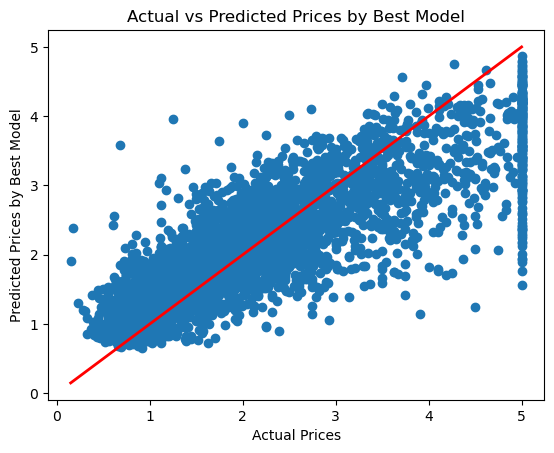

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import itertools
from joblib import Parallel, delayed

# Загрузка данных
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='Price')

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение первой модели
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train)

# Различные виды распределений
distributions = {
    'uniform': lambda num_samples: np.random.rand(num_samples),
    'normal': lambda num_samples: np.random.randn(num_samples),
    'exponential': lambda num_samples: np.random.exponential(scale=1.0, size=num_samples),
    # 'gamma': lambda num_samples: np.random.gamma(shape=2.0, scale=1.0, size=num_samples)
}

num_samples = 1000
best_mse = float('inf')
best_r2 = float('-inf')
best_distribution = None
best_new_X = None
best_new_y = None

# Все возможные комбинации распределений для каждого столбца
distribution_names = list(distributions.keys())
all_combinations = list(itertools.product(distribution_names, repeat=X_train.shape[1]))

# Функция для генерации данных и оценки модели
def evaluate_combination(combination):
    random_data = np.zeros((num_samples, X_train.shape[1]))
    
    for col_idx, dist_name in enumerate(combination):
        random_data[:, col_idx] = distributions[dist_name](num_samples)
    
    random_data_df = pd.DataFrame(random_data, columns=california.feature_names)
    scaler = StandardScaler()
    random_data_scaled = scaler.fit_transform(random_data_df)
    
    generated_targets = model.predict(random_data_scaled)
    
    new_X = pd.DataFrame(random_data, columns=california.feature_names)
    new_y = pd.Series(generated_targets, name='Generated_Price')
    
    new_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    new_model.fit(new_X, new_y)
    
    y_pred_new_model = new_model.predict(pd.DataFrame(X_test_scaled, columns=california.feature_names))
    
    mse_new_model = mean_squared_error(y_test, y_pred_new_model)
    r2_new_model = r2_score(y_test, y_pred_new_model)
    
    return combination, mse_new_model, r2_new_model, new_X, new_y

# Параллельное выполнение
results = Parallel(n_jobs=-1)(delayed(evaluate_combination)(comb) for comb in all_combinations)

# Поиск лучшего результата
for combination, mse_new_model, r2_new_model, new_X, new_y in results:
    if mse_new_model < best_mse:
        print(f"найдены данные получше... mse: {mse_new_model} r2:{r2_new_model}")
        best_mse = mse_new_model
        best_r2 = r2_new_model
        best_distribution = combination
        best_new_X = new_X
        best_new_y = new_y

print(f"Best distribution combination: {best_distribution}, Best MSE: {best_mse:.2f}, Best R^2: {best_r2:.2f}")

# Обучение и оценка модели с наилучшей комбинацией распределений
best_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
best_model.fit(best_new_X, best_new_y)

y_pred_best_model = best_model.predict(pd.DataFrame(X_test_scaled, columns=california.feature_names))

plt.scatter(y_test, y_pred_best_model)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices by Best Model')
plt.title('Actual vs Predicted Prices by Best Model')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import itertools
from joblib import Parallel, delayed


class ModelExtractor:
    model_executor = None

    # Различные виды распределений
    distributions = {
        'uniform': lambda num_samples: np.random.rand(num_samples),
        'normal': lambda num_samples: np.random.randn(num_samples),
        'exponential': lambda num_samples: np.random.exponential(scale=1.0, size=num_samples),
        'gamma': lambda num_samples: np.random.gamma(shape=2.0, scale=1.0, size=num_samples)
    }

    # Все возможные комбинации распределений для каждого столбца
    distribution_names = list(distributions.keys())
    all_combinations = list(itertools.product(distribution_names, repeat=X_train.shape[1]))


    num_samples = 1000
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_distribution = None
    best_new_X = None
    best_new_y = None
    
    def __init__(self,model_type):
        if model_type == "random_forest":
            self.model_executor = RandomForestRegressor()
        if model_type == "gradient_boosting":
            self.model_executor = GradientBoostingRegressor()
        
        
    # Функция для генерации данных и оценки модели
    def evaluate_combination(self, combination):
        random_data = np.zeros((num_samples, X_train.shape[1]))
        
        for col_idx, dist_name in enumerate(combination):
            random_data[:, col_idx] = distributions[dist_name](num_samples)
        
        random_data_df = pd.DataFrame(random_data, columns=california.feature_names)
        scaler = StandardScaler()
        random_data_scaled = scaler.fit_transform(random_data_df)
        
        generated_targets = model.predict(random_data_scaled)
        
        new_X = pd.DataFrame(random_data, columns=california.feature_names)
        new_y = pd.Series(generated_targets, name='Generated_Price')
        
        new_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        new_model.fit(new_X, new_y)
        
        y_pred_new_model = new_model.predict(pd.DataFrame(X_test_scaled, columns=california.feature_names))
        
        mse_new_model = mean_squared_error(y_test, y_pred_new_model)
        r2_new_model = r2_score(y_test, y_pred_new_model)
        
        return combination, mse_new_model, r2_new_model, new_X, new_y

    def fit(self, x, y):
        # Параллельное выполнение
        results = Parallel(n_jobs=-1)(delayed(self.evaluate_combination)(comb) for comb in self.all_combinations)
        
        # Поиск лучшего результата
        for combination, mse_new_model, r2_new_model, new_X, new_y in results:
            if mse_new_model < best_mse:
                print(f"найдены данные получше... mse: {mse_new_model} r2:{r2_new_model}")
                self.best_mse = mse_new_model
                self.best_r2 = r2_new_model
                self.best_distribution = combination
                self.best_new_X = new_X
                self.best_new_y = new_y
        
        print(f"Best distribution combination: {self.best_distribution}, Best MSE: {self.best_mse:.2f}, Best R^2: {self.best_r2:.2f}")
        
        # Обучение и оценка модели с наилучшей комбинацией распределений
        self.model_executor.fit(best_new_X, best_new_y)
        
        y_pred_best_model = self.model_executor.predict(pd.DataFrame(X_test_scaled, columns=california.feature_names))
        self.model_executor.fit(x, y)


# Загрузка данных
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='Price')

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение первой модели
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train)

# Различные виды распределений
distributions = {
    'uniform': lambda num_samples: np.random.rand(num_samples),
    'normal': lambda num_samples: np.random.randn(num_samples),
    'exponential': lambda num_samples: np.random.exponential(scale=1.0, size=num_samples),
    # 'gamma': lambda num_samples: np.random.gamma(shape=2.0, scale=1.0, size=num_samples)
}

num_samples = 1000
best_mse = float('inf')
best_r2 = float('-inf')
best_distribution = None
best_new_X = None
best_new_y = None

# Все возможные комбинации распределений для каждого столбца
distribution_names = list(distributions.keys())
all_combinations = list(itertools.product(distribution_names, repeat=X_train.shape[1]))

# Функция для генерации данных и оценки модели
def evaluate_combination(combination):
    random_data = np.zeros((num_samples, X_train.shape[1]))
    
    for col_idx, dist_name in enumerate(combination):
        random_data[:, col_idx] = distributions[dist_name](num_samples)
    
    random_data_df = pd.DataFrame(random_data, columns=california.feature_names)
    scaler = StandardScaler()
    random_data_scaled = scaler.fit_transform(random_data_df)
    
    generated_targets = model.predict(random_data_scaled)
    
    new_X = pd.DataFrame(random_data, columns=california.feature_names)
    new_y = pd.Series(generated_targets, name='Generated_Price')
    
    new_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    new_model.fit(new_X, new_y)
    
    y_pred_new_model = new_model.predict(pd.DataFrame(X_test_scaled, columns=california.feature_names))
    
    mse_new_model = mean_squared_error(y_test, y_pred_new_model)
    r2_new_model = r2_score(y_test, y_pred_new_model)
    
    return combination, mse_new_model, r2_new_model, new_X, new_y

# Параллельное выполнение
results = Parallel(n_jobs=-1)(delayed(evaluate_combination)(comb) for comb in all_combinations)

# Поиск лучшего результата
for combination, mse_new_model, r2_new_model, new_X, new_y in results:
    if mse_new_model < best_mse:
        print(f"найдены данные получше... mse: {mse_new_model} r2:{r2_new_model}")
        best_mse = mse_new_model
        best_r2 = r2_new_model
        best_distribution = combination
        best_new_X = new_X
        best_new_y = new_y

print(f"Best distribution combination: {best_distribution}, Best MSE: {best_mse:.2f}, Best R^2: {best_r2:.2f}")

# Обучение и оценка модели с наилучшей комбинацией распределений
best_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
best_model.fit(best_new_X, best_new_y)

y_pred_best_model = best_model.predict(pd.DataFrame(X_test_scaled, columns=california.feature_names))

plt.scatter(y_test, y_pred_best_model)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices by Best Model')
plt.title('Actual vs Predicted Prices by Best Model')
plt.show()